<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/Trabajo_Uriel_Aprendizaje_produndo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from  google.colab import drive
 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
train_path = '/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/training'
val_path   = '/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/validation'
test_path   = '/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/evaluation'

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 
import matplotlib.image as img
from numpy.core.fromnumeric import argmax

# Keras
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.applications import ResNet50

from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
#Creamos listas con todos los nombres de los ficheros 
train = [os.path.join(train_path,img) for img in os.listdir(train_path)]
val   = [os.path.join(val_path,img) for img in os.listdir(val_path)]
test   = [os.path.join(val_path,img) for img in os.listdir(val_path)]


len(train),len(val),len(test)

(300, 90, 90)

In [5]:
train[0:3]

['/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/training/1_33.jpg',
 '/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/training/1_74.jpg',
 '/content/drive/MyDrive/IA3/Datasets/food_3_100_30_30/training/1_24.jpg']

In [6]:
#Troceamos por la ultima '/' y por '_' para quedarnos el primer numero y lo pasamos a entero
train_y = [int(img.split("/")[-1].split("_")[0]) for img in train]
val_y = [int(img.split("/")[-1].split("_")[0]) for img in val]
test_y = [int(img.split("/")[-1].split("_")[0]) for img in test]
num_classes = 3

#One hot encoding para tener las etiquetas
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)

In [7]:
#Vemos lo que obtenemos con el 'one hot'
print(train_y[0:20])
print(y_train[0:20])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


Datos de entrenamiento en:  3 clases
[100, 100, 100]


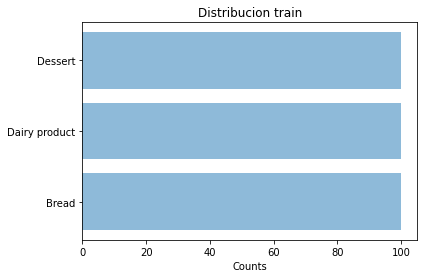

In [8]:
print("Datos de entrenamiento en: ", num_classes, "clases")
print([train_y.count(i) for i in range(num_classes)])
 
food_classes = ('Bread','Dairy product','Dessert','Egg','Fried food','Meat', 'Noodles/Pasta','Rice','Seafood', 'Soup', 'Vegetable/Fruit')
food_classes = food_classes[0:num_classes]
 
y_pos = np.arange(len(food_classes))
counts = [train_y.count(i) for i in range(num_classes)]
 
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, food_classes)
plt.xlabel('Counts')
plt.title('Distribucion train')
 
plt.show()

In [9]:
print("Datos de validacion en: ", num_classes, "clases")
print([val_y.count(i) for i in range(num_classes)])
print("Datos de test en: ", num_classes, "clases")
print([test_y.count(i) for i in range(num_classes)])

Datos de validacion en:  3 clases
[30, 30, 30]
Datos de test en:  3 clases
[30, 30, 30]


In [10]:
#Clase para mostrar imagenes
def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            ax = plt.subplot2grid((4,4),(i,j))  
            ax.set_title('Clase: ' + str(train_y[k]) )     
            plt.imshow(image)            
            k = k+1
    #Muestra
    plt.show()

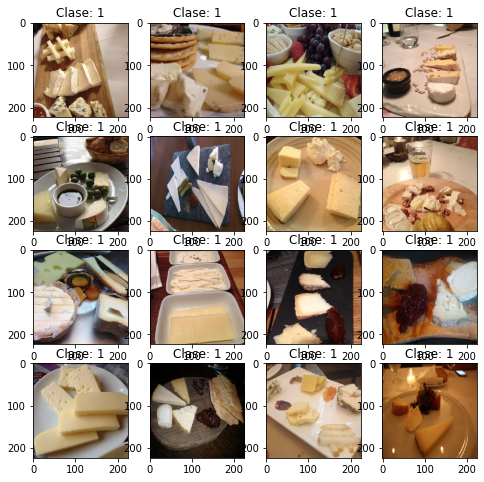

In [11]:
show_imgs(train)

In [12]:
def create_features(dataset):
 
    x_scratch = []

    k=0

    #Bucle sobre las imagenes
    for imagePath in dataset:
 
        #Se cargan las imagenes a tamaño 224
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)

        k = k+1
        print('convertida:', k, ' de ', len(dataset))
 
    x = np.vstack(x_scratch)
    return x

In [ ]:
train_x = create_features(train)
val_x = create_features(val)
test_x = create_features(test)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

In [14]:
# Creating a checkpointer
checkpointer = ModelCheckpoint(filepath='scratchmodel.best.hdf5',
                               verbose=1,save_best_only=True)
# load the VGG16 network
print("[INFO loading network...")
model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])
model_vgg.summary()

[INFO loading network...
58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                     

In [15]:
model_transfer_full = Sequential()
model_transfer_full.add(model_vgg)
model_transfer_full.add(GlobalAveragePooling2D())
model_transfer_full.add(Dropout(0.2))
model_transfer_full.add(Dense(100, activation='relu'))
model_transfer_full.add(Dense(num_classes, activation='softmax'))
model_transfer_full.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 14,766,291
Trainable params: 14,766,291
Non-trainable params: 0
____________________________________________

In [16]:
opt = Adam(learning_rate=0.00001)
model_transfer_full.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model_transfer_full.fit(train_x, y_train, batch_size=32, epochs=10,
          validation_data=(val_x, y_val), callbacks=[checkpointer],verbose=1, shuffle=True)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 3.5177 - accuracy: 0.3633
Epoch 1: val_loss improved from inf to 1.51516, saving model to scratchmodel.best.hdf5
10/10 [==============================] - 34s 2s/step - loss: 3.5177 - accuracy: 0.3633 - val_loss: 1.5152 - val_accuracy: 0.4667
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.0734 - accuracy: 0.5367
Epoch 2: val_loss improved from 1.51516 to 0.97317, saving model to scratchmodel.best.hdf5
10/10 [==============================] - 9s 877ms/step - loss: 1.0734 - accuracy: 0.5367 - val_loss: 0.9732 - val_accuracy: 0.4889
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7840 - accuracy: 0.6500
Epoch 3: val_loss improved from 0.97317 to 0.88796, saving model to scratchmodel.best.hdf5
10/10 [==============================] - 9s 874ms/step - loss: 0.7840 - accuracy: 0.6500 - val_loss: 0.8880 - val_accuracy: 0.5556
Epoch 4/10
10/10 [==============================] - ETA: 0

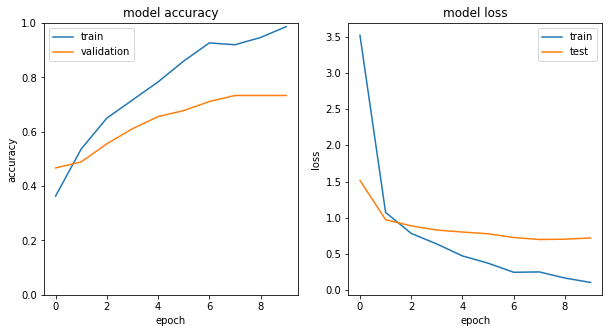

In [17]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))
 
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.ylim([0, 1])
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
 
plot_accuracy_loss(history)

In [18]:
preds = np.argmax(model_transfer_full.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,num_classes))


Accuracy on Test Data:  0.7333333333333333

Number of correctly identified imgaes:  66 



array([[26,  1,  3],
       [ 1, 25,  4],
       [10,  5, 15]])

## Congelamos la mitad de VGG-16


In [38]:
# load the VGG16 network
print("[INFO] loading network...")
model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])
 
# Freeze the layers except the last 9 layers
for layer in model_vgg.layers[:-9]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in model_vgg.layers:
    print(layer, layer.trainable)

[INFO] loading network...
<keras.engine.input_layer.InputLayer object at 0x7f83119e1c50> False
<keras.layers.convolutional.Conv2D object at 0x7f821cbe3590> False
<keras.layers.convolutional.Conv2D object at 0x7f821cbe39d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8296497e50> False
<keras.layers.convolutional.Conv2D object at 0x7f821cbd3250> False
<keras.layers.convolutional.Conv2D object at 0x7f821cf05c10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f821cb6f050> False
<keras.layers.convolutional.Conv2D object at 0x7f821cb79290> False
<keras.layers.convolutional.Conv2D object at 0x7f821cb69ad0> False
<keras.layers.convolutional.Conv2D object at 0x7f821cb79fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f821cb88450> True
<keras.layers.convolutional.Conv2D object at 0x7f821cb88310> True
<keras.layers.convolutional.Conv2D object at 0x7f821ce25410> True
<keras.layers.convolutional.Conv2D object at 0x7f821cb92f90> True
<keras.layers.pooling.MaxPooling2D obj

In [39]:
model_transfer_half = Sequential()
model_transfer_half.add(model_vgg)
model_transfer_half.add(GlobalAveragePooling2D())
model_transfer_half.add(Dropout(0.2))
model_transfer_half.add(Dense(100, activation='relu'))
model_transfer_half.add(Dense(num_classes, activation='softmax'))
model_transfer_half.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               51300     
                                                                 
 dense_7 (Dense)             (None, 3)                 303       
                                                                 
Total params: 14,766,291
Trainable params: 13,030,803
Non-trainable params: 1,735,488
__________________________________

In [56]:
opt = Adam(lr=0.00001)
model_transfer_half.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model_transfer_half.fit(train_x, y_train, batch_size=32, epochs=50,
          validation_data=(val_x, y_val), callbacks=[checkpointer],verbose=1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9700
Epoch 1: val_loss did not improve from 0.44828
10/10 [==============================] - 7s 503ms/step - loss: 0.1570 - accuracy: 0.9700 - val_loss: 0.9514 - val_accuracy: 0.6556
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9500
Epoch 2: val_loss did not improve from 0.44828
10/10 [==============================] - 4s 455ms/step - loss: 0.1416 - accuracy: 0.9500 - val_loss: 0.7909 - val_accuracy: 0.6889
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9833
Epoch 3: val_loss did not improve from 0.44828
10/10 [==============================] - 5s 458ms/step - loss: 0.0829 - accuracy: 0.9833 - val_loss: 0.8078 - val_accuracy: 0.7556
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9933
Epoch 4: val_loss did not improve from 0.44828
10/10 [==============================] - 5s

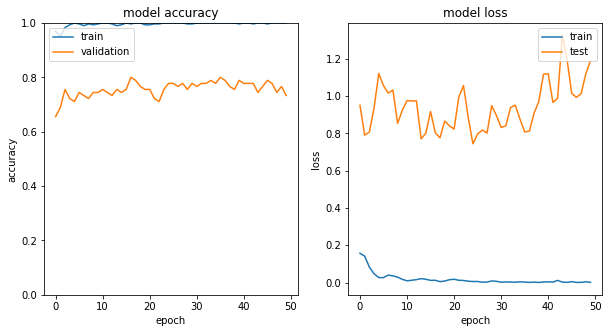

In [57]:
plot_accuracy_loss(history)

In [60]:
preds = np.argmax(model_transfer_half.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,num_classes))


Accuracy on Test Data:  0.7333333333333333

Number of correctly identified imgaes:  66 



array([[28,  1,  1],
       [ 3, 20,  7],
       [ 7,  5, 18]])

#Resnet50

In [ ]:
# load the Resnet50 network
print("[INFO loading network...")
model_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])
model_resnet.summary()

In [41]:
# Freeze the layers except the last 6 layers
for layer in model_resnet.layers[:-6]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in model_vgg.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f83119e1c50> False
<keras.layers.convolutional.Conv2D object at 0x7f821cbe3590> False
<keras.layers.convolutional.Conv2D object at 0x7f821cbe39d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8296497e50> False
<keras.layers.convolutional.Conv2D object at 0x7f821cbd3250> False
<keras.layers.convolutional.Conv2D object at 0x7f821cf05c10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f821cb6f050> False
<keras.layers.convolutional.Conv2D object at 0x7f821cb79290> False
<keras.layers.convolutional.Conv2D object at 0x7f821cb69ad0> False
<keras.layers.convolutional.Conv2D object at 0x7f821cb79fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f821cb88450> True
<keras.layers.convolutional.Conv2D object at 0x7f821cb88310> True
<keras.layers.convolutional.Conv2D object at 0x7f821ce25410> True
<keras.layers.convolutional.Conv2D object at 0x7f821cb92f90> True
<keras.layers.pooling.MaxPooling2D object at 0x7f821cba08d0> Tru

In [42]:
model_transfer_half_resnet = Sequential()
model_transfer_half_resnet.add(model_resnet)
model_transfer_half_resnet.add(GlobalAveragePooling2D())
model_transfer_half_resnet.add(Dropout(0.2))
model_transfer_half_resnet.add(Dense(100, activation='relu'))
model_transfer_half_resnet.add(Dense(num_classes, activation='softmax'))
model_transfer_half_resnet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 100)               204900    
                                                                 
 dense_9 (Dense)             (None, 3)                 303       
                                                                 
Total params: 23,792,915
Trainable params: 1,260,947
Non-trainable params: 22,531,968
__________________________________

In [53]:
opt = Adam(lr=0.00001)
model_transfer_half_resnet.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

history3 = model_transfer_half_resnet.fit(train_x, y_train, batch_size=32, epochs=50,
          validation_data=(val_x, y_val), callbacks=[checkpointer],verbose=1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.9467
Epoch 1: val_loss improved from 0.60014 to 0.59141, saving model to scratchmodel.best.hdf5
10/10 [==============================] - 12s 464ms/step - loss: 0.2797 - accuracy: 0.9467 - val_loss: 0.5914 - val_accuracy: 0.7111
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.9267
Epoch 2: val_loss improved from 0.59141 to 0.58553, saving model to scratchmodel.best.hdf5
10/10 [==============================] - 3s 324ms/step - loss: 0.2858 - accuracy: 0.9267 - val_loss: 0.5855 - val_accuracy: 0.7333
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.9500
Epoch 3: val_loss improved from 0.58553 to 0.58242, saving model to scratchmodel.best.hdf5
10/10 [==============================] - 3s 326ms/step - loss: 0.2679 - accuracy: 0.9500 - val_loss: 0.5824 - val_accuracy: 0.7222
Epoch 4/50
10/10 [==============================] -

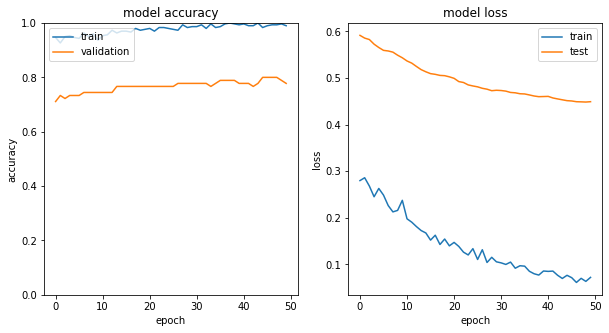

In [54]:
plot_accuracy_loss(history3)

In [55]:
preds = np.argmax(model_transfer_half_resnet.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,num_classes))


Accuracy on Test Data:  0.7777777777777778

Number of correctly identified imgaes:  70 



array([[25,  2,  3],
       [ 1, 24,  5],
       [ 5,  4, 21]])

#Comprobaciones Test

Ground truth:  0   Bread
Predict:  0   Bread


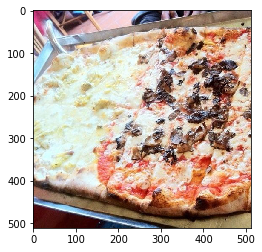

In [67]:
id=258

image = img.imread(train[id])
plt.imshow(image[:,:,:], cmap='gray', vmin = 0, vmax = 255,interpolation='none')
print("Ground truth: ", y_train[id].argmax(), " ", food_classes[y_train[id].argmax()])
#plt.imshow(train_x[id])

p = model_transfer_half_resnet.predict(np.expand_dims(train_x[id], axis=0))
print("Predict: ", p.argmax(), " ", food_classes[p.argmax()])

#Comprobaciones Validacion



Ground truth:  2   Dessert
Predict:       2   Dessert


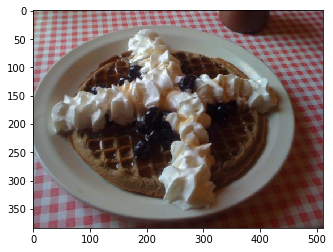

In [65]:
id=49

image = img.imread(val[id])
plt.imshow(image[:,:,:], cmap='gray', vmin = 0, vmax = 255,interpolation='none')
print("Ground truth: ", y_val[id].argmax(), " ", food_classes[y_val[id].argmax()])
#plt.imshow(train_x[id])

p = model_transfer_half_resnet.predict(np.expand_dims(val_x[id], axis=0))
print("Predict:      ", p.argmax(), " ", food_classes[p.argmax()])

##TEST DATA AUGMENTATION


In [68]:
import tensorflow as tf

In [69]:
tf.__version__

'2.8.0'

In [70]:
# To generate GIFs
!pip install -q imageio

In [71]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [72]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [73]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

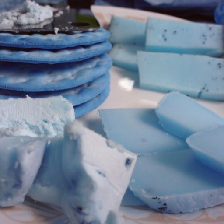

In [74]:
#test
train_images = train_x
train_labels = train_y

train_images = train_images.reshape(train_images.shape[0], 224, 224, 3).astype('float32')
train_images = (train_images - [127.5]) / 127.5 # Normalize the images to [-1, 1]

from keras.preprocessing.image import array_to_img
image = train_images[1,:,:,:]
array_to_img(image)

In [75]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [76]:
#test
BUFFER_SIZE = 300
BATCH_SIZE = 25

In [77]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [78]:
#test
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(4, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(8, 8), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 224, 224, 3)

    return model

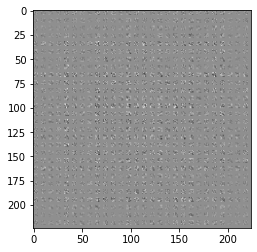

In [79]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

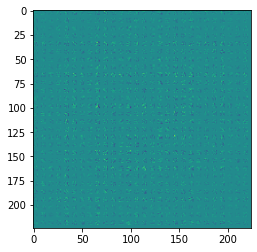

In [80]:
#test
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [81]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [96]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[224, 224, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [97]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00014766]], shape=(1, 1), dtype=float32)


In [98]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [99]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [100]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [101]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [102]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [103]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [104]:
#test
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [105]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [106]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    #Cambiado a 4 epochs
    if (epoch + 1) % 4 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [107]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [108]:
#test
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(28,28))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

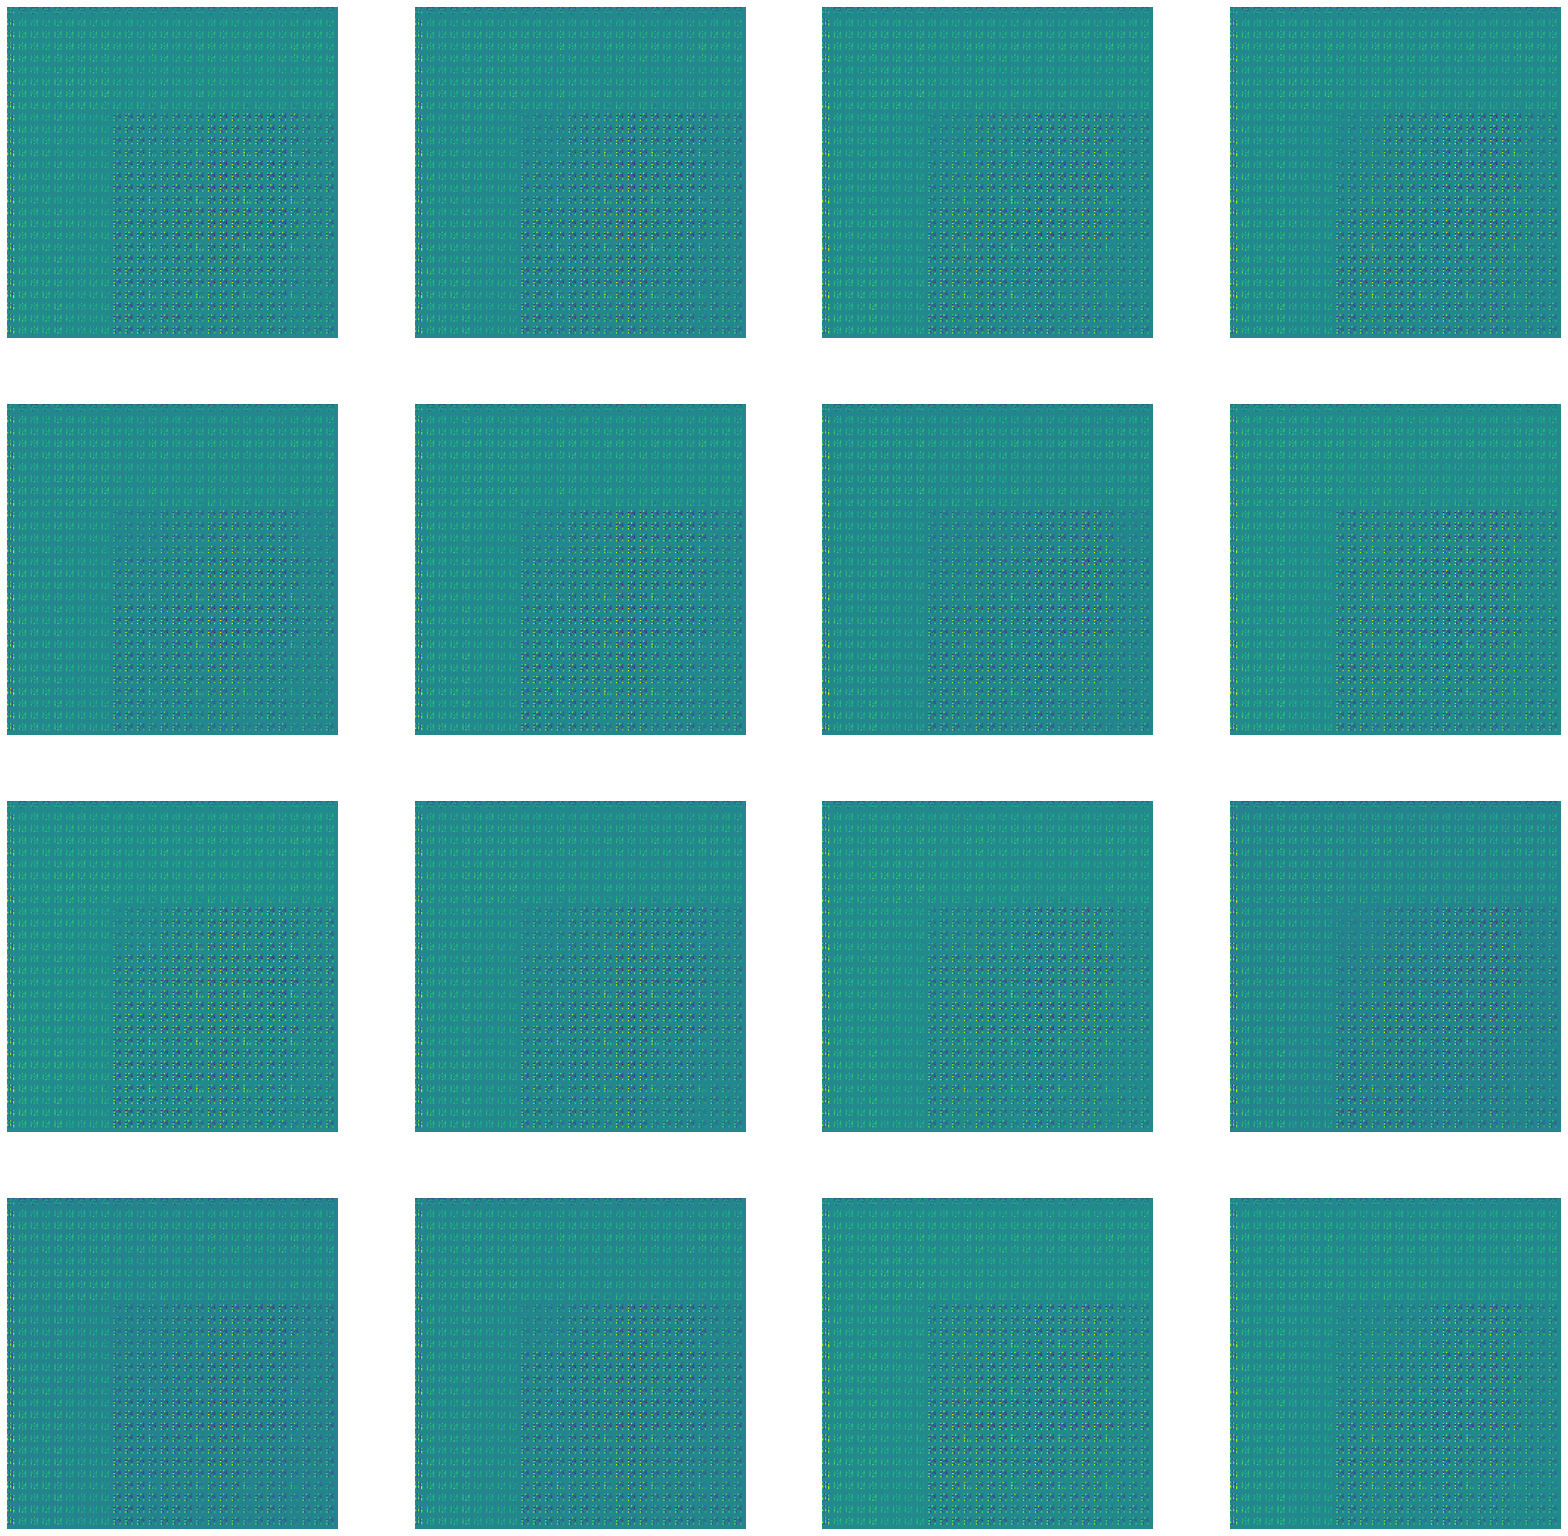

In [109]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

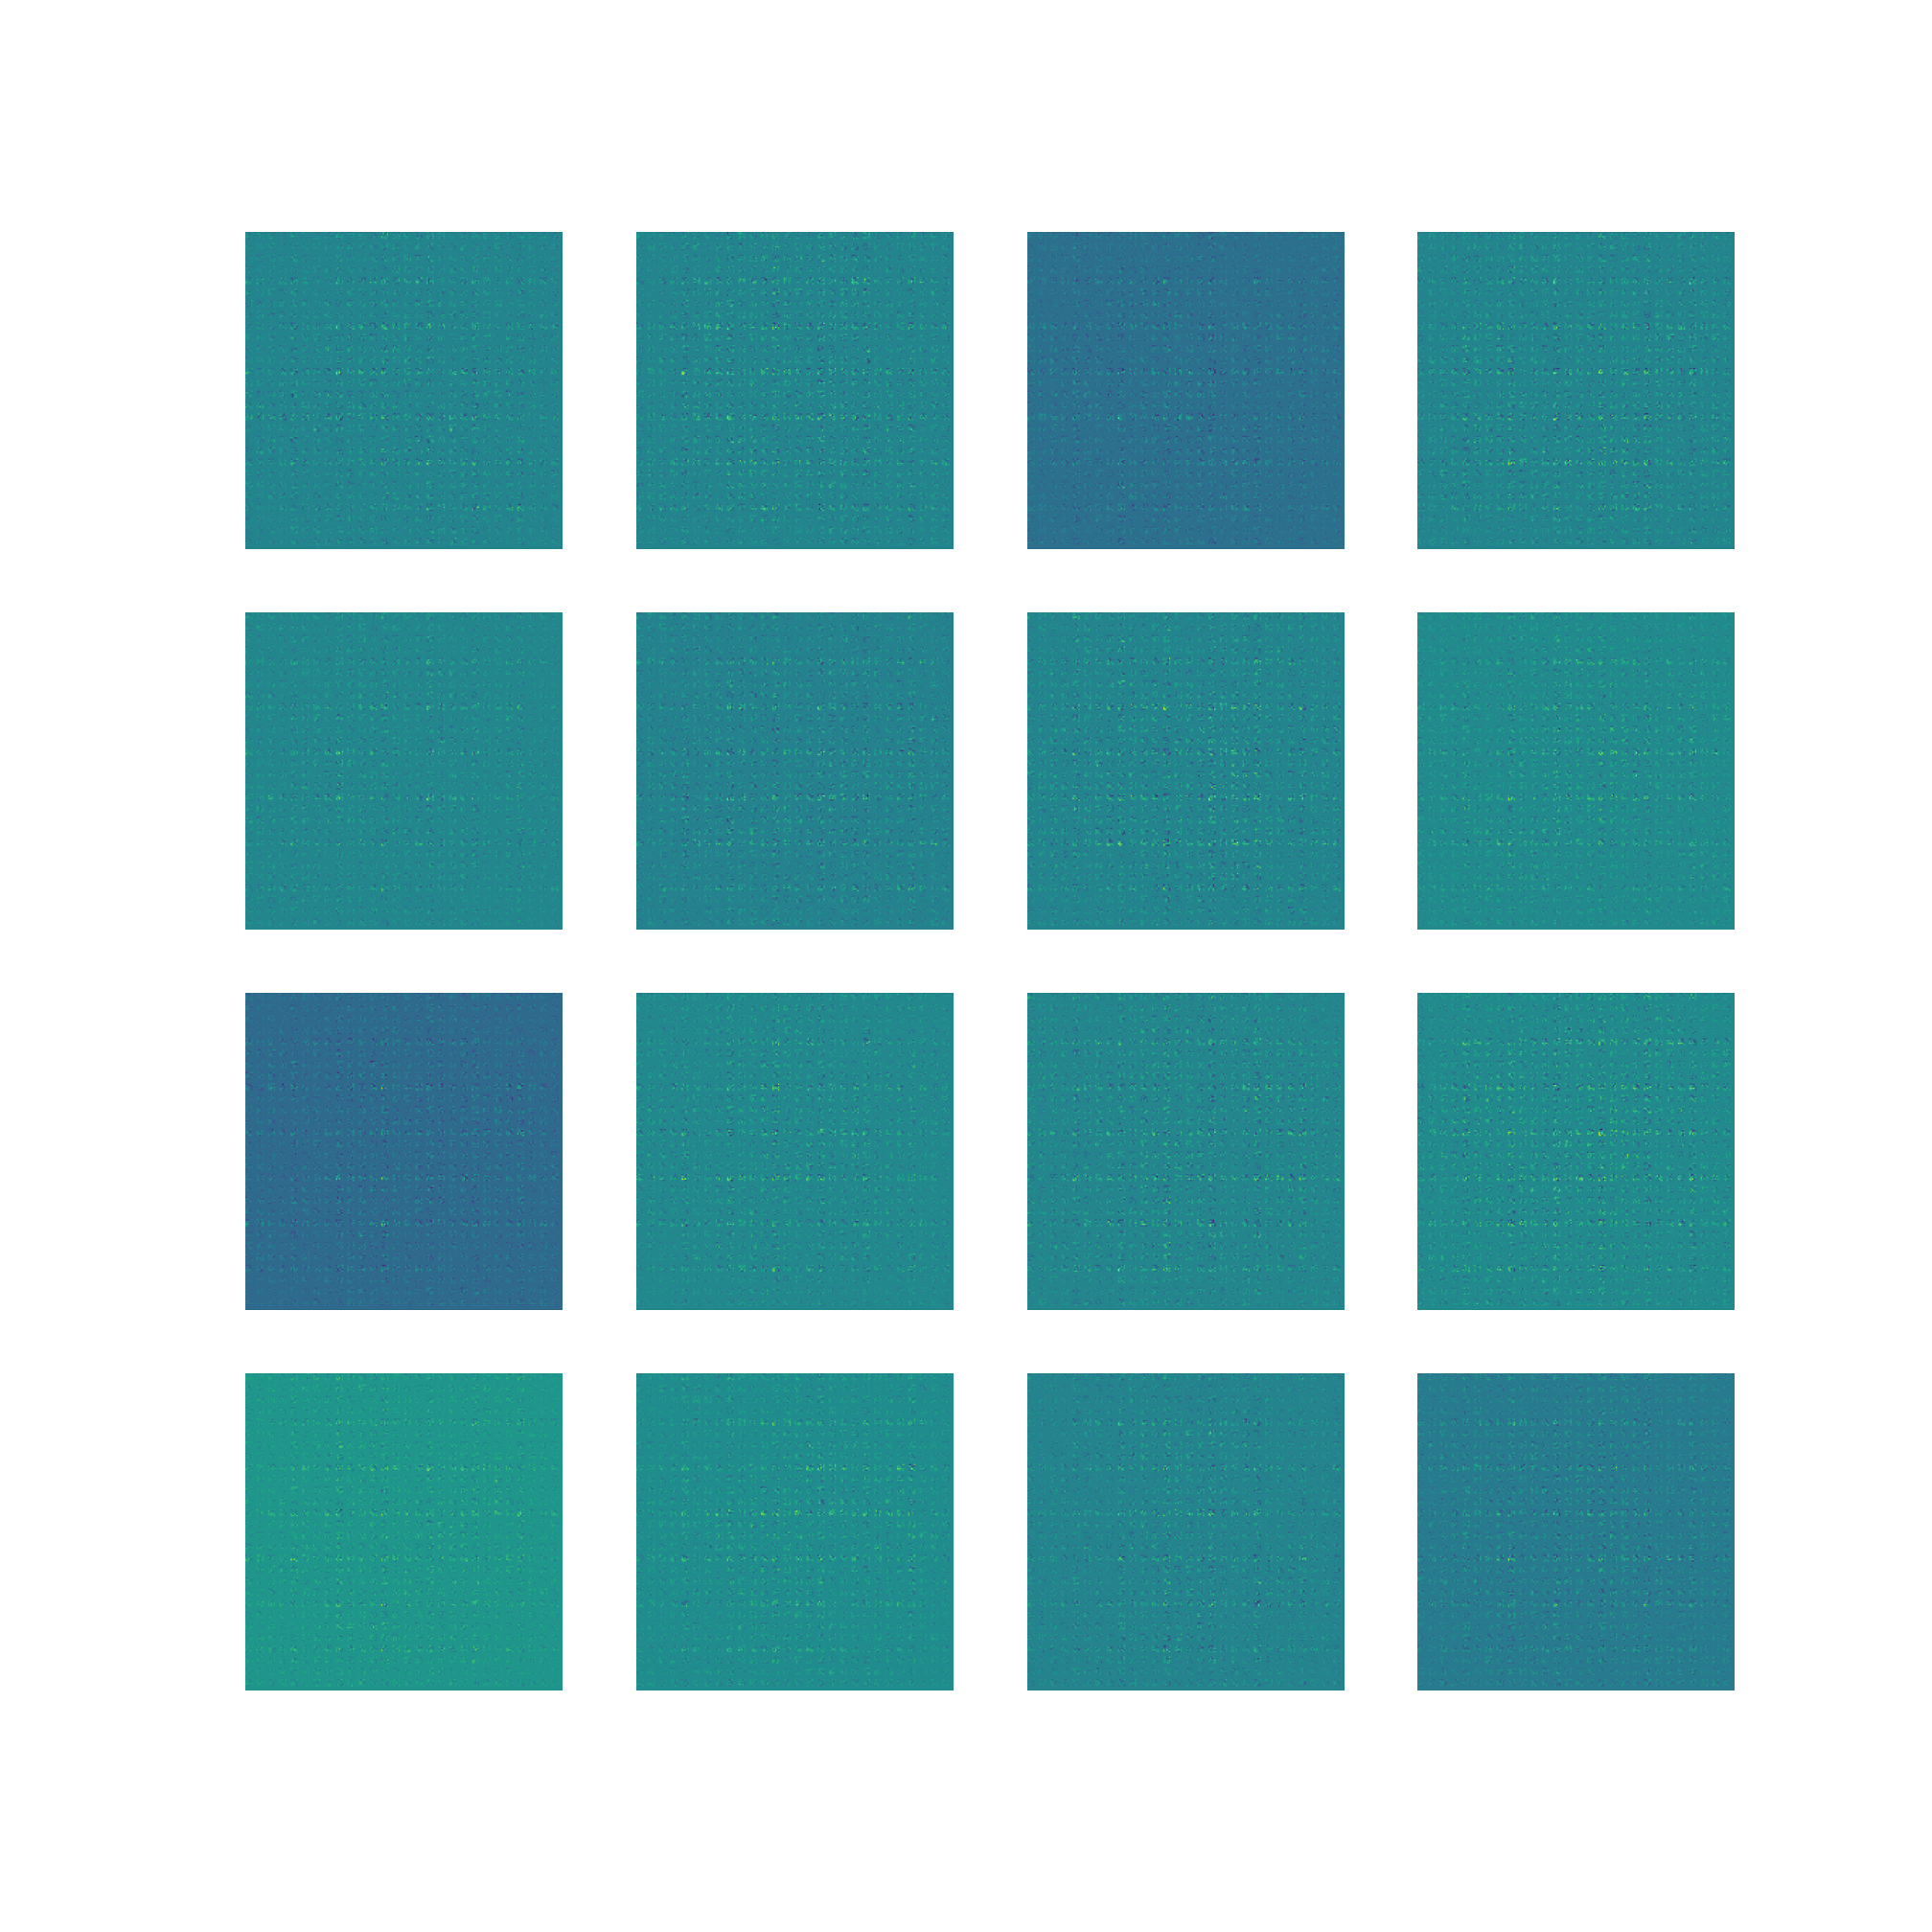

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)